# Demo: SSVQE BLFQ Observables

WQ 07/18/2022

##### The Subspace-search variational quantum eigensolver (SSVQE) algorithm is described in [Subspace-search variational quantum eigensolver for excited states](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033062)

##### This notebook is a demo on how to use SSVQE simulation result to calculate BLFQ observables: 
* State visualzation with density matrix
* Decay constants
* Parton distribution functions

##### which is used in the recent paper, [Solving hadron structures using the basis light-front quantization approach on quantum computers](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.4.043193).

##### Note:
1. In practice, we would need to run simulation multiple times to obtain reasonable results.
2. The generated data are stored as PICKLE files under output/prev_simulations/ directory.

In [1]:
import os, sys, importlib
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from time import time
%matplotlib inline

from qiskit import Aer, IBMQ
from qiskit.algorithms import NumPyEigensolver, NumPyMinimumEigensolver
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler
from qiskit.providers.aer.noise import NoiseModel
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.visualization import plot_state_hinton

# Local package
library = os.path.abspath("./src")
assert os.path.isdir(library)
if library not in sys.path: 
    sys.path.append(library)
    
import operators, tools, visualization, simulator 
import init_state, ansatz, optimization_result
import solver_VQE, solver_SSVQE
import blfq, blfq_quantum, print_formatter

def reload():
    importlib.reload(operators)
    importlib.reload(tools)
    importlib.reload(visualization)
    importlib.reload(simulator)
    importlib.reload(init_state)
    importlib.reload(ansatz)
    importlib.reload(optimization_result)
    importlib.reload(solver_SSVQE)
    importlib.reload(solver_VQE)
    importlib.reload(blfq)
    importlib.reload(blfq_quantum)
    importlib.reload(print_formatter)
reload()

from simulator import sv_qi, qasm_qi, qasm_sim, sv_sim, make_qi
from solver_SSVQE import get_exp_val
qasm_qi_big = make_qi(qasm_sim, 20000)


# Problem setup

In [5]:
fn_N1L1 = f'H_data/N1L1/Ham_Total_a0p89_mf0p30_kap0p56_mJ0_mug0.02_grid64_N1_L1_lambda0p00.dat'
fn_N4L1 = f'H_data/N4L1/Ham_Total_a0p89_mf0p38_kap0p56_mJ0_mug0.02_grid64_N4_L1_lambda0p00.dat'
fn_N4L3 = f"H_data/N4L3/Ham_Total_a0p89_mf0p40_kap0p56_mJ0_mug0.02_grid64_N4_L3_lambda0p00.dat"

In [6]:
def get_Ham_and_Operator_and_Exact_from_files(N=1, L=1, encoding='compact', verbose=0):
    fn = ""
    if N==1 and L==1: fn = fn_N1L1
    if N==4 and L==1: fn = fn_N4L1
    if N==4 and L==3: fn = fn_N4L3
    assert fn != "", "Invalid N and L parameters!"
    Hamiltonian = tools.load_Ham_data_by_threshold(fn)
    Hamiltonian = Hamiltonian*1000*1000    # mass squared energy units: GeV^2 to MeV^2
    operator = operators.MatrixEncoding(Hamiltonian, encoding=encoding).get_operator()
    exact = list(sorted(np.linalg.eigvals(Hamiltonian)))
    if verbose != 0: 
        print(Hamiltonian)
        print()
        print(operator)
        print()
        print(exact)    
    return Hamiltonian, operator, exact

Hamiltonian, operator, exact = get_Ham_and_Operator_and_Exact_from_files(N=1, L=1, encoding='compact', verbose=1)

[[ 568486.7        0.     25428.09       0.  ]
 [      0.   1700976.         0.    -15766.91]
 [  25428.09       0.    568486.7        0.  ]
 [      0.    -15766.91       0.   1700976.  ]]

1134731.35 * II
- 566244.6499999999 * IZ
+ 4830.590000000001 * XI
+ 20597.5 * XZ

[543058.6100000001, 593914.79, 1685209.09, 1716742.91]


In [7]:
operator[0].to_pauli_op().primitive.__str__()

'II'

In [8]:
# sanity checking
spect_N1L1 = f'H_data/N1L1/spectrum_a0p89_mf0p30_kap0p56_mJ0_mug0.02_grid64_N1_L1_lambda0p00.dat'
spect_N4L1 = f'H_data/N4L1/spectrum_a0p89_mf0p38_kap0p56_mJ0_mug0.02_grid64_N4_L1_lambda0p00.dat'
spect_N4L3 = f"H_data/N4L3/spectrum_a0p89_mf0p40_kap0p56_mJ0_mug0.02_grid64_N4_L3_lambda0p00.dat"
evect_N1L1 = f'H_data/N1L1/evect_a0p89_mf0p30_kap0p56_mJ0_mug0.02_grid64_N1_L1_lambda0p00.dat'
evect_N4L1 = f'H_data/N4L1/evect_a0p89_mf0p38_kap0p56_mJ0_mug0.02_grid64_N4_L1_lambda0p00.dat'
evect_N4L3 = f"H_data/N4L3/evect_a0p89_mf0p40_kap0p56_mJ0_mug0.02_grid64_N4_L3_lambda0p00.dat"

In [10]:
blfq_N1L1 = blfq.BLFQ_file(fn_N1L1, spect_N1L1, evect_N1L1)
blfq_N1L1.get_all_decays()

#       f_p       f_v
1   178.184     0.000
2     0.000   178.184
3     0.000     0.000
4     0.000     0.000


In [11]:
blfq_N4L1 = blfq.BLFQ_file(fn_N4L1, spect_N4L1, evect_N4L1)
blfq_N4L1.get_all_decays()

#       f_p       f_v
1   199.364     0.000
2     0.000   227.634
3     0.000     0.000
4   112.398     0.000


In [12]:
blfq_N4L3 = blfq.BLFQ_file(fn_N4L3, spect_N4L3, evect_N4L3)
blfq_N4L3.get_all_decays()

#       f_p       f_v
1   199.340     0.000
2     0.000   229.254
3     0.000     0.000
4   116.460     0.000


[543058.6100000001, 593914.79, 1685209.09, 1716742.91]
Expected cost = 1475911.14125
Depth = 8
Num Params = 12


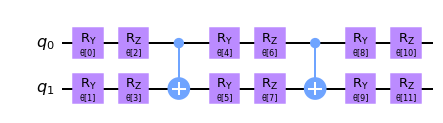

In [13]:
n_qubit = 2
n_state = 4

Hamiltonian, operator, exact = get_Ham_and_Operator_and_Exact_from_files(N=1, L=1, encoding='compact')
print(exact[:n_state])
print("Expected cost =", sum(exact[i]*(1/2**i) for i in range(n_state)))

# ANSATZ
myansatz = EfficientSU2(n_qubit, ['ry','rz'], 'linear', reps=2).decompose()
print("Depth =", myansatz.depth())
print("Num Params =", myansatz.num_parameters)

# INITIAL STATES
ref_states = init_state.get_ref_states(n_qubit, n_state)

myansatz.draw()

# Optimization results

In [ ]:
# QASM sampler
qi_QASM = make_qi(qasm_sim, 20000)
sampler_QASM = CircuitSampler(qi_QASM)

# NQASM sampler
provider = IBMQ.load_account()
backend = provider.get_backend('ibm_nairobi')
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
qi_NQASM = QuantumInstance(qasm_sim, shots=20000, noise_model=noise_model, coupling_map=coupling_map)
sampler_NQASM = CircuitSampler(qi_NQASM)

# NMQASM sampler
qi_NMQASM = QuantumInstance(qasm_sim, shots=20000, noise_model=noise_model, coupling_map=coupling_map,
                                measurement_error_mitigation_cls=CompleteMeasFitter, cals_matrix_refresh_period=90)
sampler_NMQASM = CircuitSampler(qi_NMQASM)

In [83]:
#  LOAD PREVIOUS SIMULATION DATA
params_SV = optimization_result.OptimizationResult().load('output/prev_simulations/ssvqe_2qubit_4ref_exact_LBFGSB_07_18_16_27_48.pk').final_param[0]

params_QASM = optimization_result.OptimizationResult().load('output/prev_simulations/ssvqe_2qubit_4ref_qasm_SPSA_07_18_16_27_09.pk').final_param[0]

params_NQASM = optimization_result.OptimizationResult().load('output/prev_simulations/ssvqe_2qubit_4ref_noise_SPSA_07_18_16_11_56.pk').final_param[0]

params_NMQASM = optimization_result.OptimizationResult().load('output/prev_simulations/ssvqe_2qubit_4ref_noise_miti_SPSA_07_18_15_44_54.pk').final_param[0]

OptimizationResult loaded.
OptimizationResult loaded.
OptimizationResult loaded.
OptimizationResult loaded.


# Density matrix

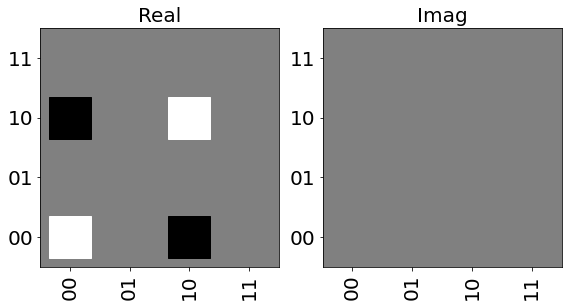

In [46]:
# EXACT
blfq_q = blfq_quantum.BLFQ_Quantum(myansatz, params_SV, ref_states, sampler=None)
p = blfq_q.get_eigenstate(0)
visualization.plot_state_hinton2(p, fs=20)

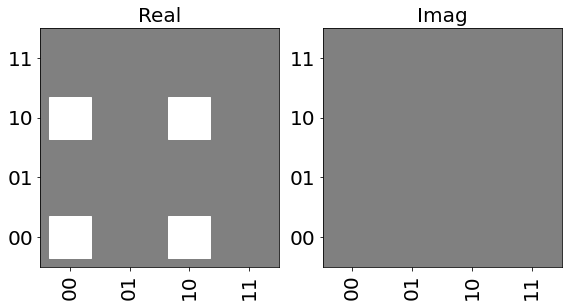

In [47]:
q = blfq_q.get_eigenstate(1)
visualization.plot_state_hinton2(q, fs=20)

In [20]:
# CALCULATE DECAY CONSTANT BASED ON DENSITY MATRIX
np.abs(blfq.compute_decay_base_on_quantum_amp(blfq_N1L1.get_evect(0), p.data, 0.30, 0.56))

0.17818381418787335

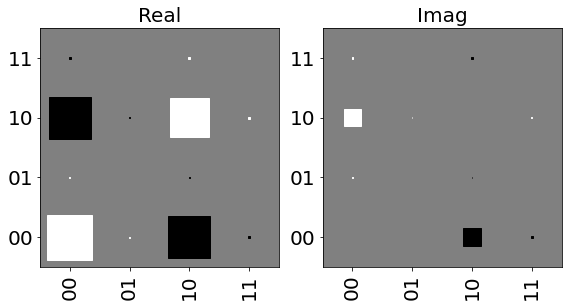

In [48]:
# QASM
blfq_q = blfq_quantum.BLFQ_Quantum(myansatz, params_QASM, ref_states, sampler=sampler_QASM)
p = blfq_q.get_eigenstate(0)
visualization.plot_state_hinton2(p, fs=20)

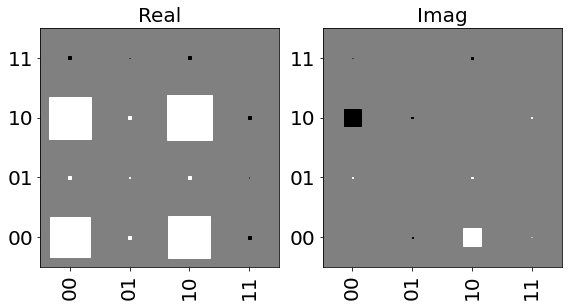

In [49]:
q = blfq_q.get_eigenstate(1)
visualization.plot_state_hinton2(q, fs=20)

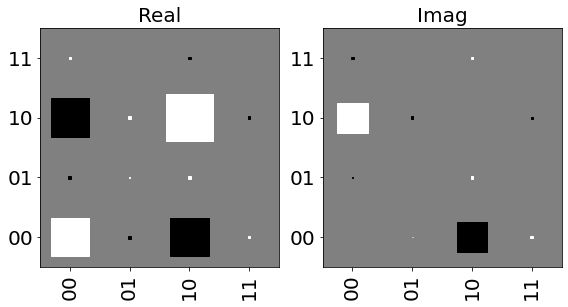

In [50]:
# NOISE QASM
blfq_q = blfq_quantum.BLFQ_Quantum(myansatz, params_NQASM, ref_states, sampler=sampler_NQASM)
p = blfq_q.get_eigenstate(0)
visualization.plot_state_hinton2(p, fs=20)

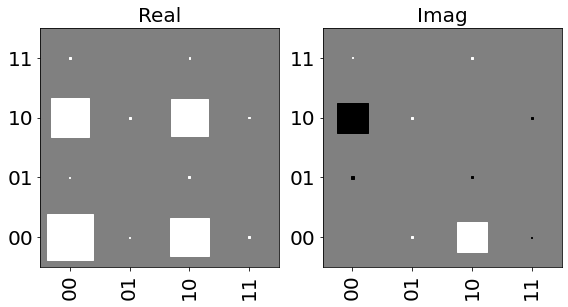

In [51]:
q = blfq_q.get_eigenstate(1)
visualization.plot_state_hinton2(q, fs=20)

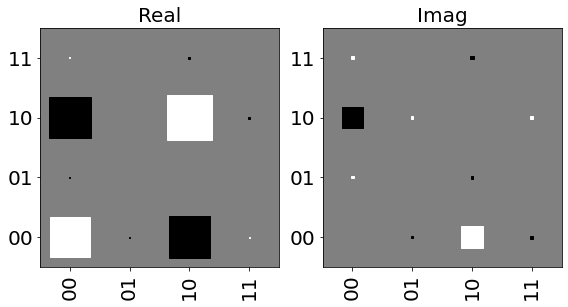

In [53]:
# NOISE MITIGATED QASM
blfq_q = blfq_quantum.BLFQ_Quantum(myansatz, params_NMQASM, ref_states, sampler=sampler_NMQASM)
p = blfq_q.get_eigenstate(0)
visualization.plot_state_hinton2(p, fs=20)

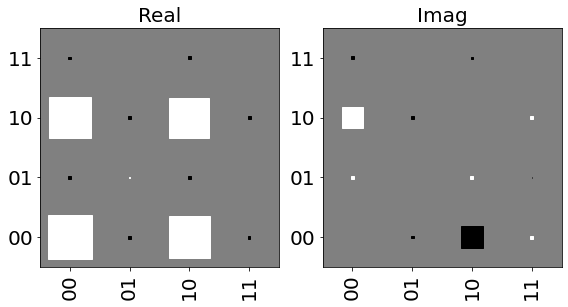

In [54]:
q = blfq_q.get_eigenstate(1)
visualization.plot_state_hinton2(q, fs=20)

In [55]:
print(np.abs(blfq.compute_decay_base_on_quantum_amp(blfq_N1L1.get_evect(0), p.data, 0.3, 0.56, 'p')))
print(np.abs(blfq.compute_decay_base_on_quantum_amp(blfq_N1L1.get_evect(1), blfq_q.get_eigenstate(1).data, 0.3, 0.56, 'v')))

0.1763377504473757
0.17633531868136976


# Decay constant

In [56]:
np.round(blfq_N1L1.get_evect(), 3)

array([[ 0.   ,  0.   ,  0.   , -1.   ,  1.   ,  0.707],
       [ 0.   ,  0.   ,  1.   , -1.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   , -1.   , -0.707],
       [ 0.   ,  0.   ,  1.   ,  1.   , -1.   ,  0.   ]])

In [57]:
pi_op = blfq_quantum.construct_decay_op_from_blfq(blfq_N1L1, 0, decay='p', verbose=0)
rho_op = blfq_quantum.construct_decay_op_from_blfq(blfq_N1L1, 1, decay='v', verbose=0)

In [58]:
print(pi_op)

0.007937367938438392 * II
+ 0.007937367938438392 * IZ
- 0.007937367938438392 * XI
- 0.007937367938438392 * XZ


In [59]:
print(rho_op)

0.007937367938438392 * II
+ 0.007937367938438392 * IZ
+ 0.007937367938438392 * XI
+ 0.007937367938438392 * XZ


In [61]:
params = params_SV
sampler = None
print(blfq_quantum.get_decay_from_sim(myansatz, params, pi_op, init_state.get_ref_states(2, 4)[0], sampler=sampler, exp_method='factory'))
print(blfq_quantum.get_decay_from_sim(myansatz, params, rho_op, init_state.get_ref_states(2, 4)[1], sampler=sampler, exp_method='factory'))

[178.18381419   0.        ]
[178.18381419   0.        ]


In [62]:
qi_QASM = make_qi(qasm_sim, 20000)
sampler_QASM = CircuitSampler(qi_QASM)

In [63]:
params = params_QASM
sampler = sampler_QASM
print(blfq_quantum.get_decay_from_sim(myansatz, params, pi_op, init_state.get_ref_states(2, 4)[0], sampler=sampler, exp_method='pauli'))
print(blfq_quantum.get_decay_from_sim(myansatz, params, rho_op, init_state.get_ref_states(2, 4)[1], sampler=sampler, exp_method='pauli'))

[177.09803972   4.95938214]
[177.21005195   4.82811302]


In [67]:
params = params_NQASM
sampler = sampler_NQASM
print(blfq_quantum.get_decay_from_sim(myansatz, params, pi_op, init_state.get_ref_states(2, 4)[0], sampler=sampler, exp_method='pauli'))
print(blfq_quantum.get_decay_from_sim(myansatz, params, rho_op, init_state.get_ref_states(2, 4)[1], sampler=sampler, exp_method='pauli'))

[165.02938184   8.85486945]
[166.28951387   8.67558084]


In [65]:
params = params_NMQASM
sampler = sampler_NMQASM
print(blfq_quantum.get_decay_from_sim(myansatz, params, pi_op, init_state.get_ref_states(2, 4)[0], sampler=sampler, exp_method='pauli'))
print(blfq_quantum.get_decay_from_sim(myansatz, params, rho_op, init_state.get_ref_states(2, 4)[1], sampler=sampler, exp_method='pauli'))

[174.91080865   6.48425815]
[174.43822324   6.69531149]


# Parton Distribution Function

In [70]:
print(blfq_quantum.construct_pdf_op_from_blfq(blfq_N1L1,0,0.3,verbose=1))

Group: (n,m,s1,s2) = (0, 0, -1, 1)
Group: (n,m,s1,s2) = (0, 0, 1, -1)
[[ 1.278 -1.176  0.     0.   ]
 [-1.176  1.083  0.     0.   ]
 [ 0.     0.     1.278 -1.176]
 [ 0.     0.    -1.176  1.083]]
1.1803312523403884 * II
- 1.1762945075143838 * IX
+ 0.09753510569494128 * IZ


In [73]:
def plot_pdfs(xs, pdfs, errors=[], labels=[r'$q_\pi(x)$', r'$q_\rho(x)$'],
              fs=24, figsize=(8,6), 
              legend_loc='best',
              text_loc=(0.5, 1), text='',
              no_left_label=False
             ):
    if 0 not in xs and 1 not in xs:
        xs = np.concatenate([[0], xs, [1]])
        pdfs = [np.concatenate([[0], pdf, [0]]) for pdf in pdfs]
        if errors: errors = [np.concatenate([[0], error, [0]]) for error in errors]
        # print(xs, pdfs, errors)
    fig, axs = plt.subplots(1, 1, squeeze=False, figsize=figsize)
    plt.rcParams["font.size"] = fs
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.sans-serif"] = ["Times New Roman"]
    colors = ['r', 'g', 'b', 'orange', 'c', 'm', 'y', 'k']
    linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
    markers = ['o', 's', '<', '>']
    xmax = 0
    for axis in ['top','bottom','left','right']:
        axs[0,0].spines[axis].set_linewidth(1.5)


    for i, pdf in enumerate(pdfs):
        axs[0,0].plot(xs, pdf, linestyle=linestyles[i], lw=2, color=colors[i % len(colors)], 
                      markersize=8, marker=markers[i], 
                      label=labels[i],
                      zorder=i)
        if errors != []: 
            terrs = errors[i]
            axs[0,0].errorbar(xs, pdf, yerr=terrs, lw=0,
                              color=colors[i], capsize=10, capthick=1, elinewidth=0.5, marker=markers[i], markersize=0)
    if not no_left_label: 
        axs[0,0].set_ylabel(r"$q(x)$", fontsize=fs) 
    axs[0,0].set_xlabel(r"$x$", fontsize=fs)
    epslon = 0.05
    axs[0,0].set_ylim(bottom=0-epslon, top=1.8+epslon)
    axs[0,0].set_xlim(left=0-epslon, right=1+epslon)
    axs[0,0].tick_params(axis='both', which='major', labelsize=fs) # choose 'both', 'x', 'y'

    axs[0,0].axhline(y=1, xmin=0, xmax=1, ls=linestyles[2], lw=2, color='gray', #label='Exact' if i==0 else None,
                    zorder=10)
    axs[0,0].legend(fontsize=fs, loc=legend_loc)
    # axs.plot()
    axs[0,0].ticklabel_format(useOffset=False)

    font = {'family': "Times New Roman",
        'color':  'darkred',
        'weight': 'normal',
        'size': fs,
    }    
    axs[0,0].text(*text_loc, text, fontdict=font)

    plt.show()


In [72]:
params = params_SV
xs = np.arange(0.1,1.0, 0.1)
pdf_0 = np.array([blfq_quantum.get_pdf_from_sim(myansatz, params, blfq_quantum.construct_pdf_op_from_blfq(blfq_N1L1, 0, x), init_state.get_ref_states(2, 4)[0], sampler=None, exp_method='factory') for x in xs])
pdf_1 = np.array([blfq_quantum.get_pdf_from_sim(myansatz, params, blfq_quantum.construct_pdf_op_from_blfq(blfq_N1L1, 1, x), init_state.get_ref_states(2, 4)[1], sampler=None, exp_method='factory') for x in xs])
pdf_SV = [pdf_0[:,0], pdf_1[:,0]]
pdf_err_SV = [pdf_0[:,1], pdf_1[:,1]]
pdf_SV

[array([0.48312953, 0.93521746, 1.27786706, 1.4895598 , 1.56102452,
        1.48955899, 1.27786566, 0.93521592, 0.48312847]),
 array([0.48312783, 0.93521499, 1.27786482, 1.4895585 , 1.56102452,
        1.48956029, 1.2778679 , 0.93521838, 0.48313017])]

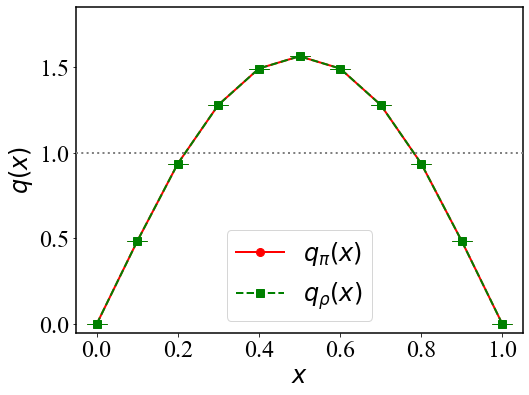

In [74]:
plot_pdfs(xs, pdf_SV, errors=pdf_err_SV)

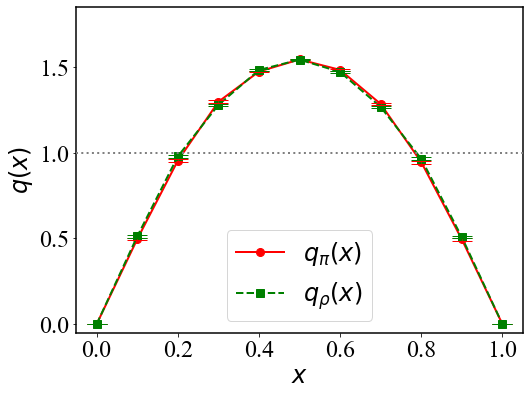

In [78]:
params = params_NMQASM
sampler = sampler_NMQASM
xs = np.arange(0.1,1.0, 0.1)
pdf_0 = np.array([blfq_quantum.get_pdf_from_sim(myansatz, params, blfq_quantum.construct_pdf_op_from_blfq(blfq_N1L1, 0, x), init_state.get_ref_states(2, 4)[0], sampler=sampler, exp_method='pauli') for x in xs])
pdf_1 = np.array([blfq_quantum.get_pdf_from_sim(myansatz, params, blfq_quantum.construct_pdf_op_from_blfq(blfq_N1L1, 1, x), init_state.get_ref_states(2, 4)[1], sampler=sampler, exp_method='pauli') for x in xs])
pdf_NMQASM = [pdf_0[:,0], pdf_1[:,0]]
pdf_err_NMQASM = [pdf_0[:,1], pdf_1[:,1]]
plot_pdfs(xs, pdf_NMQASM, errors=pdf_err_NMQASM)